In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

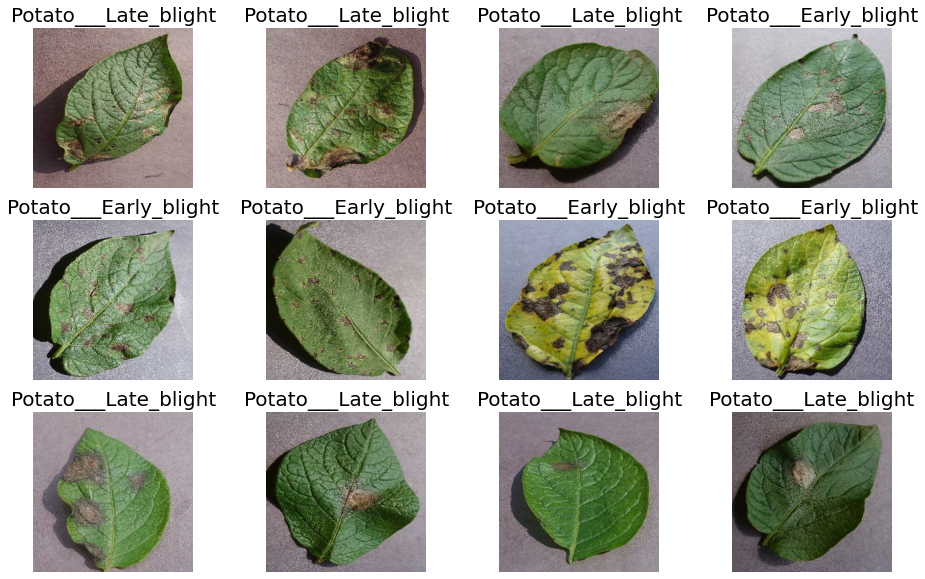

In [5]:
plt.figure(figsize=(16,10))
for img,lbl in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[lbl[i]],{'fontsize':20})
        plt.axis("off")

In [6]:
    # train_data = dataset.take(54)
    # test_data  = dataset.skip(54)
    # val_data   = test_data.take(6)
    # test_data = test_data.skip(6)

In [7]:
# print(f"Training Data:{len(train_data)} , Test Data:{len(test_data)}, Validation Data:{len(val_data)}")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_data,val_data,test_data = get_dataset_partitions_tf(dataset)

In [10]:
print(f"Training Data:{len(train_data)} , Test Data:{len(test_data)}, Validation Data:{len(val_data)}")

Training Data:54 , Test Data:8, Validation Data:6


In [11]:
train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1, 
        epochs=8,
    )

Epoch 1/8
54/54 [==============================] - 88s 2s/step - loss: 0.8739 - accuracy: 0.4809 - val_loss: 0.7390 - val_accuracy: 0.6250
Epoch 2/8
54/54 [==============================] - 80s 1s/step - loss: 0.6850 - accuracy: 0.6846 - val_loss: 0.6912 - val_accuracy: 0.6927
Epoch 3/8
54/54 [==============================] - 74s 1s/step - loss: 0.5196 - accuracy: 0.7564 - val_loss: 0.4922 - val_accuracy: 0.8281
Epoch 4/8
54/54 [==============================] - 78s 1s/step - loss: 0.3232 - accuracy: 0.8721 - val_loss: 0.3336 - val_accuracy: 0.8333
Epoch 5/8
54/54 [==============================] - 76s 1s/step - loss: 0.2459 - accuracy: 0.8981 - val_loss: 0.2604 - val_accuracy: 0.8906
Epoch 6/8
54/54 [==============================] - 83s 2s/step - loss: 0.2258 - accuracy: 0.9144 - val_loss: 0.3425 - val_accuracy: 0.8490
Epoch 7/8
54/54 [==============================] - 80s 1s/step - loss: 0.1939 - accuracy: 0.9282 - val_loss: 0.1732 - val_accuracy: 0.9323
Epoch 8/8
54/54 [==========